In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
df = pd.read_excel(r'C:\Users\tejab\OneDrive\Desktop\ML_Casestudy\Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:

print("Data Info")
df.info()

print("\nMissing Values Count")
print(df.isnull().sum())

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

Missing Values Count
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


## Data Cleaning
**Observations:**
1. ~135k rows have missing CustomerID. We cannot track churn for anonymous users, so these must be dropped.
2. InvoiceDate is currently a string (Object). It needs to be datetime.
3. Quantity can be negative (returns). For churn prediction, we care about *purchases*, so we filter for Quantity > 0.

In [5]:
# 1. Drop rows with no Customer ID
df_clean = df.dropna(subset=['CustomerID']).copy()

# 2. Convert Date to proper format
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# 3. Filter out Returns (Negative Quantity)
df_clean = df_clean[df_clean['Quantity'] > 0]

print(f"Cleaned Dataset Shape: {df_clean.shape}")
print(f"Unique Customers remaining: {df_clean['CustomerID'].nunique()}")

Cleaned Dataset Shape: (397924, 8)
Unique Customers remaining: 4339


## EDA

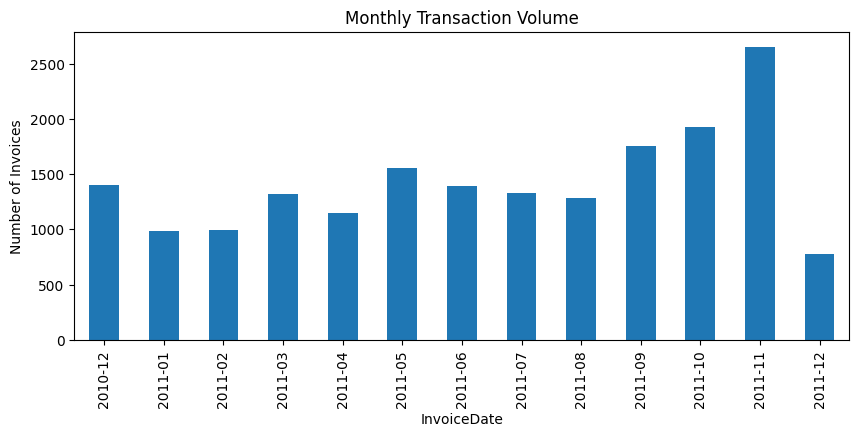

Top 5 Countries:
 Country
United Kingdom    0.890484
Germany           0.022723
France            0.020964
EIRE              0.018189
Spain             0.006245
Name: proportion, dtype: float64


In [6]:
# A. Transaction Timeline
plt.figure(figsize=(10, 4))
df_clean.groupby(df_clean['InvoiceDate'].dt.to_period('M'))['InvoiceNo'].nunique().plot(kind='bar')
plt.title("Monthly Transaction Volume")
plt.ylabel("Number of Invoices")
plt.show()

# B. Geographic Distribution (Do we need to filter by Country?)
top_countries = df_clean['Country'].value_counts(normalize=True).head(5)
print("Top 5 Countries:\n", top_countries)

**Insight:** Over 89% of our data comes from the United Kingdom. To avoid noise from international shipping delays affecting "Recency," we will filter to keep **only UK customers** for a robust model.

In [7]:
# Filter for UK only
df_uk = df_clean[df_clean['Country'] == 'United Kingdom'].copy()

## Feature Engineering (Time-Window Method)
We cannot just randomly split rows. We must split by time.
* Training Window (Features): Data before 2011-09-01.
* Target Window (Labels): Data after 2011-09-01.

If a customer purchases in the Target Window, they are Retained (0). If they disappear, they are Churned (1).

In [8]:
# Define the Cutoff Date (Approx 3 months before end of data)
cutoff_date = pd.Timestamp('2011-09-01')

print(f"Splitting data at: {cutoff_date}")

# Split the Raw Transactions
train_transactions = df_uk[df_uk['InvoiceDate'] < cutoff_date]
test_transactions = df_uk[df_uk['InvoiceDate'] >= cutoff_date]

print(f"Past Transactions (for Features): {len(train_transactions)}")
print(f"Future Transactions (for Labels): {len(test_transactions)}")

Splitting data at: 2011-09-01 00:00:00
Past Transactions (for Features): 200364
Future Transactions (for Labels): 153981


In [9]:
# FEATURE EXTRACTION
# We create features ONLY from the 'train_transactions' (The Past)
#aggregation
train_transactions['TotalSpend'] = train_transactions['Quantity'] * train_transactions['UnitPrice']
train_transactions['DayName'] = train_transactions['InvoiceDate'].dt.day_name()

customer_df = train_transactions.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (cutoff_date - x.max()).days,       # Recency
    'InvoiceNo': 'nunique',                                      # Frequency
    'TotalSpend': 'sum',                                         # Monetary
    'DayName': lambda x: x.mode()[0]                             # Favorite Day (Category)
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'DayName': 'FavDay'})

# Add Tenure separately
first_purchase = train_transactions.groupby('CustomerID')['InvoiceDate'].min()
customer_df['Tenure'] = (cutoff_date - first_purchase).dt.days

display(customer_df.head())

C:\Users\tejab\AppData\Local\Temp\ipykernel_28760\1241868688.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_transactions['TotalSpend'] = train_transactions['Quantity'] * train_transactions['UnitPrice']
C:\Users\tejab\AppData\Local\Temp\ipykernel_28760\1241868688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_transactions['DayName'] = train_transactions['InvoiceDate'].dt.day_name()


,Recency,Frequency,TotalSpend,FavDay,Tenure
CustomerID,,,,,
12346.0,225,1,77183.60,Tuesday,225
12747.0,9,8,2769.40,Tuesday,269
12748.0,1,127,13568.55,Friday,273
12749.0,30,3,2755.23,Monday,113
12820.0,226,1,170.46,Monday,226


In [10]:
#Tranformer specific feature engineering

# Most Frequent Product (High Cardinality)
rich_features = train_transactions.groupby('CustomerID').agg({
    'StockCode': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
    'Description': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
}).rename(columns={'StockCode': 'FavProductCode', 'Description': 'FavProductDesc'})

# Merge everything into one Master DataFrame
master_df = customer_df.merge(rich_features, on='CustomerID', how='left')

# Fill NaNs for safety
master_df = master_df.fillna('Unknown')

master_df.head()
master_df.info()

C:\Users\tejab\AppData\Local\Temp\ipykernel_28760\856824148.py:5: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'int'
  'StockCode': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
C:\Users\tejab\AppData\Local\Temp\ipykernel_28760\856824148.py:5: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  'StockCode': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',


<class 'pandas.core.frame.DataFrame'>
Index: 2989 entries, 12346.0 to 18287.0
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Recency         2989 non-null   int64  
 1   Frequency       2989 non-null   int64  
 2   TotalSpend      2989 non-null   float64
 3   FavDay          2989 non-null   object 
 4   Tenure          2989 non-null   int64  
 5   FavProductCode  2989 non-null   object 
 6   FavProductDesc  2989 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 186.8+ KB


Class Distribution:
Churn
0    0.587487
1    0.412513
Name: proportion, dtype: float64


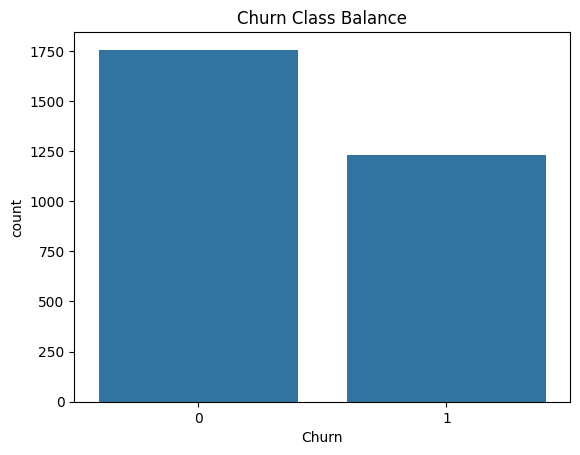

In [11]:
# TARGET CREATION
# Identify who bought something in the Future Window
active_in_future = test_transactions['CustomerID'].unique()

# If CustomerID is in 'active_in_future', Churn = 0. Else Churn = 1.
master_df['Churn'] = master_df.index.isin(active_in_future).astype(int)
master_df['Churn'] = master_df['Churn'].apply(lambda x: 0 if x == 1 else 1) # Invert logic

print("Class Distribution:")
print(master_df['Churn'].value_counts(normalize=True))

# Visualize
sns.countplot(x='Churn', data=master_df)
plt.title("Churn Class Balance")
plt.show()

          Recency  Frequency   TotalSpend      Tenure
Churn                                                
0       73.360478   4.575740  1936.055718  186.037016
1      119.633414   1.822384   676.481185  163.293593


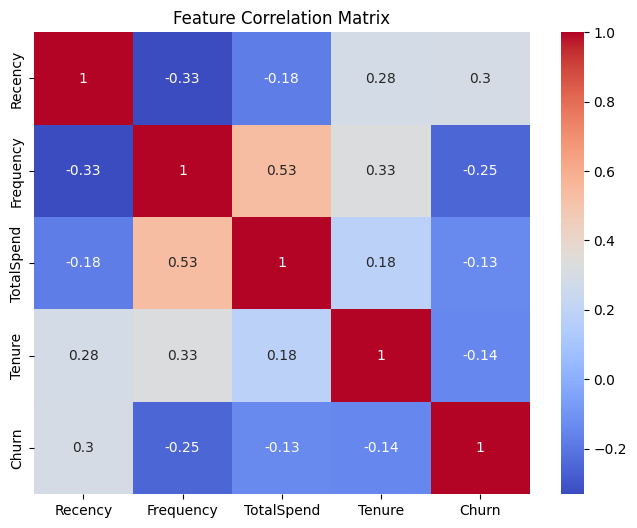

In [12]:
## 5. Feature Analysis
# Compare Churners vs Non-Churners
print(master_df.groupby('Churn')[['Recency', 'Frequency', 'TotalSpend', 'Tenure']].mean())

# Correlation Matrix
plt.figure(figsize=(8,6))
sns.heatmap(master_df[['Recency', 'Frequency', 'TotalSpend', 'Tenure', 'Churn']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [13]:
print(master_df.columns)

Index(['Recency', 'Frequency', 'TotalSpend', 'FavDay', 'Tenure',
       'FavProductCode', 'FavProductDesc', 'Churn'],
      dtype='object')


In [14]:
# Define Columns
num_cols = ['Recency', 'Frequency', 'TotalSpend', 'Tenure']
cat_cols = ['FavDay', 'FavProductCode'] # We use Code instead of Desc for simplicity

X = master_df[num_cols + cat_cols]
y = master_df['Churn']


In [15]:
# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
#RF

# 1. Select only Numerical Features (RF handles raw numbers well)
X_train_rf = X_train[num_cols]
X_test_rf = X_test[num_cols]

# 2. Train Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)

# 3. Evaluate
y_pred_rf = rf_model.predict(X_test_rf)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       351
           1       0.62      0.51      0.56       247

    accuracy                           0.67       598
   macro avg       0.66      0.65      0.65       598
weighted avg       0.66      0.67      0.66       598



In [17]:
#Tab-Transoformer model training

# 1. Scale Numerics
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

# 2. Encode Categoricals (The Critical Step)
X_train_cat_list = []
X_test_cat_list = []

# Dictionary to store vocab sizes for the model definition later
vocab_sizes = {}

for col in cat_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    le = LabelEncoder()
    # Fit on ALL data to avoid "unseen label" errors
    le.fit(pd.concat([X_train[col], X_test[col]]))
    
    X_train_cat_list.append(le.transform(X_train[col]))
    X_test_cat_list.append(le.transform(X_test[col]))
    
    vocab_sizes[col] = len(le.classes_)
    print(f"Encoded '{col}': {len(le.classes_)} unique tokens")

# Stack into matrices
X_train_cat = np.stack(X_train_cat_list, axis=1)
X_test_cat = np.stack(X_test_cat_list, axis=1)

print("\nData Ready for Transformer Training:")
print(f"Numerical Input: {X_train_num.shape}")
print(f"Categorical Input: {X_train_cat.shape}")
print(f"Vocab Sizes: {vocab_sizes}")

Encoded 'FavDay': 6 unique tokens
Encoded 'FavProductCode': 1027 unique tokens

Data Ready for Transformer Training:
Numerical Input: (2391, 4)
Categorical Input: (2391, 2)
Vocab Sizes: {'FavDay': 6, 'FavProductCode': 1027}


In [18]:
print(X_train[col])

CustomerID
13715.0    84536A
15407.0     22677
15036.0     23091
13529.0     22472
16519.0     10133
            ...  
16022.0     21058
17931.0     21188
17800.0     22147
16401.0     22197
14462.0     22948
Name: FavProductCode, Length: 2391, dtype: object


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#CUSTOM DATASET (For Dual Inputs)

class ChurnDataset(Dataset):
    def __init__(self, cat_features, num_features, labels):
        # Convert to Tensors
        self.cat_features = torch.tensor(cat_features, dtype=torch.long)
        self.num_features = torch.tensor(num_features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1) # (N, 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.cat_features[idx], self.num_features[idx], self.labels[idx]

# Create DataLoaders
batch_size = 64


train_dataset = ChurnDataset(X_train_cat, X_train_num, y_train)
test_dataset = ChurnDataset(X_test_cat, X_test_num, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda


In [20]:
class TabTransformer(nn.Module):
    def __init__(self, 
                 num_num_features, 
                 vocab_sizes, 
                 embedding_dim=32, 
                 num_transformer_blocks=2, 
                 num_heads=4):
        super(TabTransformer, self).__init__()
        
        # --- Embeddings ---
        # Create a dictionary of embeddings for each categorical feature
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=vocab_size + 1, embedding_dim=embedding_dim) 
            for vocab_size in vocab_sizes.values()
        ])
        self.num_cat_features = len(vocab_sizes)
        
        # --- Transformer Encoder ---
        # PyTorch has a built-in TransformerEncoderLayer class
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, 
            nhead=num_heads, 
            dim_feedforward=embedding_dim * 2, 
            dropout=0.1, 
            batch_first=True,
            norm_first=True # Pre-Norm usually stabilizes training
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_blocks)
        
        # --- Numerical MLP ---
        self.num_mlp = nn.Sequential(
            nn.Linear(num_num_features, 16),
            nn.ReLU()
        )
        
        # --- Final Concatenation & Classification ---
        # Input dim = (Num_Cats * Emb_Dim) + Num_MLP_Out
        final_input_dim = (self.num_cat_features * embedding_dim) + 16
        
        self.final_mlp = nn.Sequential(
            nn.Linear(final_input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1) # Output 1 logit (BCEWithLogitsLoss handles sigmoid)
        )

    def forward(self, x_cat, x_num):
        # x_cat shape: (Batch, Num_Cats)
        # x_num shape: (Batch, Num_Nums)
        
        # 1. Embed Categoricals
        embeddings = []
        for i, emb_layer in enumerate(self.embeddings):
            # Grab the i-th column, embed it, unsqueeze to (Batch, 1, Dim)
            col_emb = emb_layer(x_cat[:, i]).unsqueeze(1)
            embeddings.append(col_emb)
            
        # Concat -> (Batch, Num_Cats, Dim)
        x = torch.cat(embeddings, dim=1)
        
        # 2. Transformer Pass
        x = self.transformer_encoder(x)
        
        # 3. Flatten Transformer Output -> (Batch, Num_Cats * Dim)
        x = x.flatten(start_dim=1)
        
        # 4. Numerical Pass
        y = self.num_mlp(x_num)
        
        # 5. Concatenate & Final Output
        concat = torch.cat([x, y], dim=1)
        output = self.final_mlp(concat)
        
        return output


In [21]:
num_num_features = X_train_num.shape[1]

model = TabTransformer(
    num_num_features=num_num_features,
    vocab_sizes=vocab_sizes,
    embedding_dim=32
).to(device)

# Loss and Optimizer
# BCEWithLogitsLoss includes Sigmoid, better for numerical stability
criterion = nn.BCEWithLogitsLoss() 


# SETUP OPTIMIZER & SCHEDULER

# 1. Use AdamW (Better regularization for Transformers)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# 2. Scheduler: Reduce LR if validation accuracy stops improving
# mode='max' means we want to maximize accuracy.
# patience=5 means "wait 5 epochs before lowering LR".
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

# 3. Loss Function
criterion = nn.BCEWithLogitsLoss()


# TRAINING LOOP WITH EARLY STOPPING

print("\nTraining Model (with Scheduler & Early Stopping)")

epochs = 100  # Set high, Early Stopping will cut it short
train_losses = []
val_accuracies = []

# Early Stopping Parameters
best_val_acc = 0.0
patience = 15      # How many epochs to wait for improvement
trigger_times = 0  # Counter

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for cat_data, num_data, targets in train_loader:
        cat_data, num_data, targets = cat_data.to(device), num_data.to(device), targets.to(device)
        
        # Forward
        outputs = model(cat_data, num_data)
        loss = criterion(outputs, targets)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping (Prevents exploding gradients in Transformers)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    #VALIDATION PHASE
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for cat_data, num_data, targets in test_loader:
            cat_data, num_data, targets = cat_data.to(device), num_data.to(device), targets.to(device)
            outputs = model(cat_data, num_data)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    val_acc = correct / total
    val_accuracies.append(val_acc)
    
    # Update Scheduler
    # (It will lower LR if val_acc doesn't beat the best seen so far)
    scheduler.step(val_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    #EARLY STOPPING LOGIC
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        # Save best model
        torch.save(model.state_dict(), 'best_tab_transformer.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"\nEarly Stopping triggered! Best Accuracy: {best_val_acc:.4f}")
            # Load back the best weights
            model.load_state_dict(torch.load('best_tab_transformer.pth'))
            break

c:\Users\tejab\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
c:\Users\tejab\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training Model (with Scheduler & Early Stopping)
Epoch [1/100] | Loss: 0.6708 | Val Acc: 0.5886 | LR: 0.001000
Epoch [2/100] | Loss: 0.6285 | Val Acc: 0.6020 | LR: 0.001000
Epoch [3/100] | Loss: 0.5976 | Val Acc: 0.6355 | LR: 0.001000
Epoch [4/100] | Loss: 0.5800 | Val Acc: 0.6589 | LR: 0.001000
Epoch [5/100] | Loss: 0.5693 | Val Acc: 0.6421 | LR: 0.001000
Epoch [6/100] | Loss: 0.5607 | Val Acc: 0.6538 | LR: 0.001000
Epoch [7/100] | Loss: 0.5383 | Val Acc: 0.6605 | LR: 0.001000
Epoch [8/100] | Loss: 0.5315 | Val Acc: 0.6572 | LR: 0.001000
Epoch [9/100] | Loss: 0.5164 | Val Acc: 0.6405 | LR: 0.001000
Epoch [10/100] | Loss: 0.5005 | Val Acc: 0.6505 | LR: 0.001000
Epoch [11/100] | Loss: 0.4863 | Val Acc: 0.6304 | LR: 0.001000
Epoch [12/100] | Loss: 0.4641 | Val Acc: 0.6304 | LR: 0.001000
Epoch [13/100] | Loss: 0.4427 | Val Acc: 0.6204 | LR: 0.000500
Epoch [14/100] | Loss: 0.4188 | Val Acc: 0.6221 | LR: 0.000500
Epoch [15/100] | Loss: 0.4073 | Val Acc: 0.6204 | LR: 0.000500
Epoch [16/100]

C:\Users\tejab\AppData\Local\Temp\ipykernel_28760\1304953169.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_tab_transformer.pth'


--- Tab Transformer Results (PyTorch) ---
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       351
           1       0.59      0.58      0.58       247

    accuracy                           0.66       598
   macro avg       0.65      0.65      0.65       598
weighted avg       0.66      0.66      0.66       598



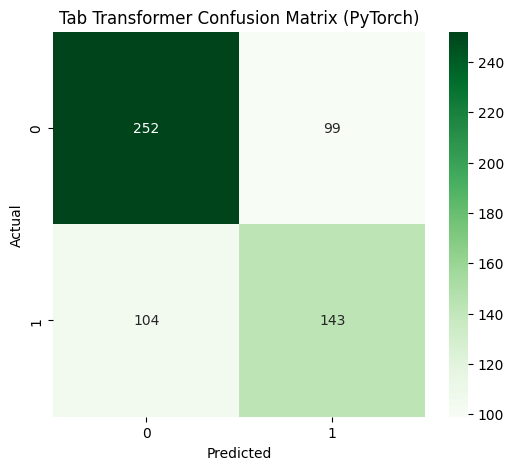

In [22]:
#Inferencing

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for cat_data, num_data, targets in test_loader:
        cat_data, num_data = cat_data.to(device), num_data.to(device)
        
        logits = model(cat_data, num_data)
        probs = torch.sigmoid(logits) # Convert logits to probability
        preds = (probs > 0.5).cpu().numpy().astype(int)
        
        all_preds.extend(preds)
        all_targets.extend(targets.cpu().numpy().astype(int))

print("\n--- Tab Transformer Results (PyTorch) ---")
print(classification_report(all_targets, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Tab Transformer Confusion Matrix (PyTorch)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [23]:
class MLPEmbedding(nn.Module):
    def __init__(self, vocab_sizes, num_num_features, embedding_dim=16):
        super().__init__()

        # Create embedding layers (one per categorical feature)
        self.emb_layers = nn.ModuleList([
            nn.Embedding(vocab_size + 1, embedding_dim)
            for vocab_size in vocab_sizes.values()
        ])

        # Total embedding output size
        self.cat_out_dim = len(vocab_sizes) * embedding_dim

        # Numerical MLP + output
        self.mlp = nn.Sequential(
            nn.Linear(self.cat_out_dim + num_num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x_cat, x_num):
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.emb_layers)]
        cat_vec = torch.cat(embedded, dim=1)
        combined = torch.cat([cat_vec, x_num], dim=1)
        return self.mlp(combined)


In [24]:
mlp_model = MLPEmbedding(vocab_sizes, num_num_features=X_train_num.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(mlp_model.parameters(), lr=0.001)

for epoch in range(40):
    mlp_model.train()
    for cat_data, num_data, targets in train_loader:
        cat_data, num_data, targets = cat_data.to(device), num_data.to(device), targets.to(device)

        outputs = mlp_model(cat_data, num_data)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [25]:
mlp_model.eval()
preds = []
with torch.no_grad():
    for cat_data, num_data, targets in test_loader:
        cat_data, num_data = cat_data.to(device), num_data.to(device)
        logits = mlp_model(cat_data, num_data)
        probs = torch.sigmoid(logits).cpu().numpy().flatten()
        preds.extend(probs > 0.5)

print("\n--- MLP w/ Embedding Results ---")
print(classification_report(y_test, preds))



--- MLP w/ Embedding Results ---
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       351
           1       0.53      0.53      0.53       247

    accuracy                           0.61       598
   macro avg       0.60      0.60      0.60       598
weighted avg       0.61      0.61      0.61       598



Tree Models

In [26]:
# Split by cardinality
low_card_cols  = [c for c in cat_cols if vocab_sizes[c] <= 20]
high_card_cols = [c for c in cat_cols if vocab_sizes[c] > 20]

print("Low-cardinality categorical:", low_card_cols)
print("High-cardinality categorical:", high_card_cols)


Low-cardinality categorical: ['FavDay']
High-cardinality categorical: ['FavProductCode']


In [27]:
from sklearn.preprocessing import LabelEncoder

def prepare_tree_data(X_train, X_test):
    Xtr = X_train[num_cols].copy()  # numeric features only
    Xte = X_test[num_cols].copy()

    # 1) Label encode low-card categorical columns
    for col in low_card_cols:
        le = LabelEncoder()
        le.fit(pd.concat([X_train[col], X_test[col]]))
        
        Xtr[col] = le.transform(X_train[col])
        Xte[col] = le.transform(X_test[col])

    # 2) Frequency encode high-card categorical columns
    for col in high_card_cols:
        freq = X_train[col].value_counts(normalize=True)
        
        Xtr[col + "_freq"] = X_train[col].map(freq).fillna(0)
        Xte[col + "_freq"] = X_test[col].map(freq).fillna(0)

    return Xtr, Xte



=== Random Forest Results ===
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       351
           1       0.63      0.59      0.61       247

    accuracy                           0.69       598
   macro avg       0.68      0.67      0.67       598
weighted avg       0.68      0.69      0.69       598



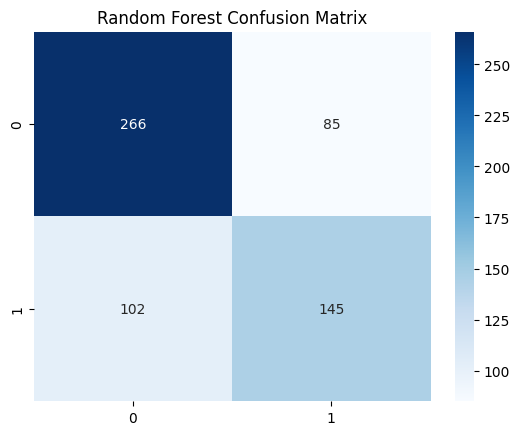

In [28]:
#Random Forest
# Prepare data
X_train_rf, X_test_rf = prepare_tree_data(X_train, X_test)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train RF
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_rf, y_train)

# Predict
rf_preds = rf_model.predict(X_test_rf)

print("\n=== Random Forest Results ===")
print(classification_report(y_test, rf_preds))

# Optional confusion matrix visual
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()


In [ ]:
# Prepare data for XGB
X_train_xgb, X_test_xgb = prepare_tree_data(X_train, X_test)

# Compute imbalance weight
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

print("scale_pos_weight:", scale_pos_weight)

import xgboost as xgb

xgb_tuned = xgb.XGBClassifier(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=10,
    min_child_weight=5,
    subsample=0.9,
    colsample_bytree=0.9,
    early_stopping_rounds=100,

    reg_lambda=2,   # L2
    reg_alpha=1,    # L1

    scale_pos_weight=scale_pos_weight,  # Handle imbalance

    gamma=0,            # Split penalty
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    tree_method="hist"  # Faster histogram algorithm
)

# Split validation set for early stopping
from sklearn.model_selection import train_test_split
Xtr, Xval, ytr, yval = train_test_split(
    X_train_xgb, y_train, test_size=0.2, random_state=42, stratify=y_train
)

xgb_tuned.fit(
    Xtr, ytr,
    eval_set=[(Xval, yval)],
    verbose=True
)

# Predictions
xgb_probs = xgb_tuned.predict_proba(X_test_xgb)[:, 1]
xgb_preds = (xgb_probs > 0.5).astype(int)

print("\n=== Tuned XGBoost Results ===")
print(classification_report(y_test, xgb_preds))

sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt='d', cmap='Greens')
plt.title("Tuned XGBoost Confusion Matrix")
plt.show()


scale_pos_weight: 1.424949290060852


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
results = pd.DataFrame({
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics,
    'MLP Embedding': mlp_metrics,
    'TabTransformer': tab_metrics
}).T

print("\n=== FINAL COMPARISON TABLE ===")
print(results)


NameError: name 'rf_metrics' is not defined